In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\5k\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.001
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model1.summary()
    return model1

In [4]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [5]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [6]:
batch_size=256

In [7]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [8]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [9]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [10]:
prediction_result_cv = []
prediction_result_ind = []

In [11]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k')

In [12]:
out = os.getcwd() + '\\'

In [13]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0     


Epoch 00024: val_loss improved from 0.53914 to 0.53765, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_0.h5
Epoch 25/300
8/8 - 0s - loss: 0.5010 - accuracy: 0.7528 - val_loss: 0.5411 - val_accuracy: 0.7556

Epoch 00025: val_loss did not improve from 0.53765
Epoch 26/300
8/8 - 0s - loss: 0.5153 - accuracy: 0.7346 - val_loss: 0.5491 - val_accuracy: 0.6889

Epoch 00026: val_loss did not improve from 0.53765
Epoch 27/300
8/8 - 0s - loss: 0.4902 - accuracy: 0.7479 - val_loss: 0.5395 - val_accuracy: 0.7556

Epoch 00027: val_loss did not improve from 0.53765
Epoch 28/300
8/8 - 0s - loss: 0.4921 - accuracy: 0.7474 - val_loss: 0.5330 - val_accuracy: 0.7644

Epoch 00028: val_loss improved from 0.53765 to 0.53295, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_0.h5
Epoch 29/300
8/8 - 0s - loss: 0.5099 - accuracy: 0.7523 - val_loss: 0.5392 - val


Epoch 00076: val_loss did not improve from 0.52667
Epoch 77/300
8/8 - 0s - loss: 0.3369 - accuracy: 0.8502 - val_loss: 0.5395 - val_accuracy: 0.7422

Epoch 00077: val_loss did not improve from 0.52667
Epoch 78/300
8/8 - 0s - loss: 0.3663 - accuracy: 0.8329 - val_loss: 0.5306 - val_accuracy: 0.7467

Epoch 00078: val_loss did not improve from 0.52667
Epoch 79/300
8/8 - 0s - loss: 0.3490 - accuracy: 0.8418 - val_loss: 0.5403 - val_accuracy: 0.7422

Epoch 00079: val_loss did not improve from 0.52667
Epoch 80/300
8/8 - 0s - loss: 0.3332 - accuracy: 0.8413 - val_loss: 0.5451 - val_accuracy: 0.7289

Epoch 00080: val_loss did not improve from 0.52667
Epoch 81/300
8/8 - 0s - loss: 0.3390 - accuracy: 0.8507 - val_loss: 0.5443 - val_accuracy: 0.7289

Epoch 00081: val_loss did not improve from 0.52667
Epoch 82/300
8/8 - 0s - loss: 0.3380 - accuracy: 0.8443 - val_loss: 0.5467 - val_accuracy: 0.7244

Epoch 00082: val_loss did not improve from 0.52667
Epoch 83/300
8/8 - 0s - loss: 0.3359 - accuracy:


Epoch 00015: val_loss improved from 0.57470 to 0.57402, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_1.h5
Epoch 16/300
8/8 - 0s - loss: 0.5344 - accuracy: 0.7182 - val_loss: 0.5773 - val_accuracy: 0.7200

Epoch 00016: val_loss did not improve from 0.57402
Epoch 17/300
8/8 - 0s - loss: 0.5525 - accuracy: 0.7074 - val_loss: 0.5772 - val_accuracy: 0.7289

Epoch 00017: val_loss did not improve from 0.57402
Epoch 18/300
8/8 - 0s - loss: 0.5420 - accuracy: 0.7098 - val_loss: 0.5764 - val_accuracy: 0.7289

Epoch 00018: val_loss did not improve from 0.57402
Epoch 19/300
8/8 - 0s - loss: 0.5331 - accuracy: 0.7336 - val_loss: 0.5757 - val_accuracy: 0.7422

Epoch 00019: val_loss did not improve from 0.57402
Epoch 20/300
8/8 - 0s - loss: 0.5251 - accuracy: 0.7350 - val_loss: 0.5739 - val_accuracy: 0.7156

Epoch 00020: val_loss improved from 0.57402 to 0.57386, saving model to D:\PycharmProjects\pythonProject\Papernew_d

8/8 - 0s - loss: 0.3925 - accuracy: 0.8186 - val_loss: 0.5711 - val_accuracy: 0.6844

Epoch 00058: val_loss did not improve from 0.54766
Epoch 59/300
8/8 - 0s - loss: 0.4290 - accuracy: 0.8018 - val_loss: 0.5538 - val_accuracy: 0.7067

Epoch 00059: val_loss did not improve from 0.54766
Epoch 60/300
8/8 - 0s - loss: 0.4056 - accuracy: 0.8097 - val_loss: 0.5644 - val_accuracy: 0.6978

Epoch 00060: val_loss did not improve from 0.54766
Epoch 61/300
8/8 - 0s - loss: 0.3984 - accuracy: 0.8166 - val_loss: 0.5503 - val_accuracy: 0.7156

Epoch 00061: val_loss did not improve from 0.54766
Epoch 62/300
8/8 - 0s - loss: 0.4446 - accuracy: 0.7919 - val_loss: 0.5579 - val_accuracy: 0.7111

Epoch 00062: val_loss did not improve from 0.54766
Epoch 63/300
8/8 - 0s - loss: 0.4092 - accuracy: 0.8216 - val_loss: 0.5489 - val_accuracy: 0.7156

Epoch 00063: val_loss did not improve from 0.54766
Epoch 64/300
8/8 - 0s - loss: 0.3931 - accuracy: 0.8196 - val_loss: 0.5587 - val_accuracy: 0.7511

Epoch 00064: v

8/8 - 0s - loss: 0.3033 - accuracy: 0.8646 - val_loss: 0.5739 - val_accuracy: 0.7022

Epoch 00112: val_loss did not improve from 0.53850
Epoch 113/300
8/8 - 0s - loss: 0.2760 - accuracy: 0.8828 - val_loss: 0.5756 - val_accuracy: 0.6933

Epoch 00113: val_loss did not improve from 0.53850
Epoch 114/300
8/8 - 0s - loss: 0.2512 - accuracy: 0.8982 - val_loss: 0.5651 - val_accuracy: 0.7022

Epoch 00114: val_loss did not improve from 0.53850
Epoch 115/300
8/8 - 0s - loss: 0.2710 - accuracy: 0.8917 - val_loss: 0.5641 - val_accuracy: 0.6978

Epoch 00115: val_loss did not improve from 0.53850
Epoch 116/300
8/8 - 0s - loss: 0.2589 - accuracy: 0.8967 - val_loss: 0.5551 - val_accuracy: 0.7111

Epoch 00116: val_loss did not improve from 0.53850
Epoch 117/300
8/8 - 0s - loss: 0.2874 - accuracy: 0.8759 - val_loss: 0.5676 - val_accuracy: 0.7111

Epoch 00117: val_loss did not improve from 0.53850
Epoch 118/300
8/8 - 0s - loss: 0.2779 - accuracy: 0.8779 - val_loss: 0.5543 - val_accuracy: 0.7067

Epoch 00

8/8 - 0s - loss: 0.5331 - accuracy: 0.7242 - val_loss: 0.6093 - val_accuracy: 0.6533

Epoch 00015: val_loss did not improve from 0.60498
Epoch 16/300
8/8 - 0s - loss: 0.5382 - accuracy: 0.7296 - val_loss: 0.6083 - val_accuracy: 0.6578

Epoch 00016: val_loss did not improve from 0.60498
Epoch 17/300
8/8 - 0s - loss: 0.5237 - accuracy: 0.7350 - val_loss: 0.5984 - val_accuracy: 0.6667

Epoch 00017: val_loss improved from 0.60498 to 0.59837, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_2.h5
Epoch 18/300
8/8 - 0s - loss: 0.5236 - accuracy: 0.7252 - val_loss: 0.5967 - val_accuracy: 0.6489

Epoch 00018: val_loss improved from 0.59837 to 0.59673, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_2.h5
Epoch 19/300
8/8 - 0s - loss: 0.5200 - accuracy: 0.7380 - val_loss: 0.5956 - val_accuracy: 0.6578

Epoch 00019: val_loss improved from 0.59673 to

8/8 - 0s - loss: 0.3993 - accuracy: 0.8186 - val_loss: 0.5984 - val_accuracy: 0.6667

Epoch 00060: val_loss did not improve from 0.58061
Epoch 61/300
8/8 - 0s - loss: 0.4151 - accuracy: 0.8161 - val_loss: 0.5855 - val_accuracy: 0.6756

Epoch 00061: val_loss did not improve from 0.58061
Epoch 62/300
8/8 - 0s - loss: 0.3844 - accuracy: 0.8235 - val_loss: 0.5848 - val_accuracy: 0.6533

Epoch 00062: val_loss did not improve from 0.58061
Epoch 63/300
8/8 - 0s - loss: 0.4114 - accuracy: 0.8122 - val_loss: 0.5832 - val_accuracy: 0.6800

Epoch 00063: val_loss did not improve from 0.58061
Epoch 64/300
8/8 - 0s - loss: 0.3743 - accuracy: 0.8270 - val_loss: 0.5827 - val_accuracy: 0.6800

Epoch 00064: val_loss did not improve from 0.58061
Epoch 65/300
8/8 - 0s - loss: 0.3970 - accuracy: 0.8102 - val_loss: 0.5894 - val_accuracy: 0.6889

Epoch 00065: val_loss did not improve from 0.58061
Epoch 66/300
8/8 - 0s - loss: 0.3796 - accuracy: 0.8304 - val_loss: 0.5867 - val_accuracy: 0.6756

Epoch 00066: v

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 5, 128)            199680    
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)             8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6801 - accuracy: 0.5531 - val_loss: 0.6629 - val_accuracy: 0.6444

Epoch 00001: val

8/8 - 0s - loss: 0.4756 - accuracy: 0.7642 - val_loss: 0.5471 - val_accuracy: 0.6933

Epoch 00034: val_loss improved from 0.55562 to 0.54709, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_3.h5
Epoch 35/300
8/8 - 0s - loss: 0.4896 - accuracy: 0.7538 - val_loss: 0.5508 - val_accuracy: 0.7289

Epoch 00035: val_loss did not improve from 0.54709
Epoch 36/300
8/8 - 0s - loss: 0.4710 - accuracy: 0.7667 - val_loss: 0.5444 - val_accuracy: 0.7200

Epoch 00036: val_loss improved from 0.54709 to 0.54444, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_3.h5
Epoch 37/300
8/8 - 0s - loss: 0.4635 - accuracy: 0.7731 - val_loss: 0.5522 - val_accuracy: 0.7022

Epoch 00037: val_loss did not improve from 0.54444
Epoch 38/300
8/8 - 0s - loss: 0.4777 - accuracy: 0.7682 - val_loss: 0.5625 - val_accuracy: 0.7022

Epoch 00038: val_loss did not improve from 0.5


Epoch 00084: val_loss did not improve from 0.53256
Epoch 85/300
8/8 - 0s - loss: 0.3266 - accuracy: 0.8641 - val_loss: 0.5591 - val_accuracy: 0.6756

Epoch 00085: val_loss did not improve from 0.53256
Epoch 86/300
8/8 - 0s - loss: 0.3340 - accuracy: 0.8547 - val_loss: 0.5445 - val_accuracy: 0.6978

Epoch 00086: val_loss did not improve from 0.53256
Epoch 87/300
8/8 - 0s - loss: 0.3275 - accuracy: 0.8532 - val_loss: 0.5441 - val_accuracy: 0.7378

Epoch 00087: val_loss did not improve from 0.53256
Epoch 88/300
8/8 - 0s - loss: 0.3186 - accuracy: 0.8527 - val_loss: 0.5382 - val_accuracy: 0.7156

Epoch 00088: val_loss did not improve from 0.53256
Epoch 89/300
8/8 - 0s - loss: 0.3176 - accuracy: 0.8646 - val_loss: 0.6347 - val_accuracy: 0.6622

Epoch 00089: val_loss did not improve from 0.53256
Epoch 90/300
8/8 - 0s - loss: 0.3286 - accuracy: 0.8557 - val_loss: 0.5513 - val_accuracy: 0.6978

Epoch 00090: val_loss did not improve from 0.53256
Epoch 91/300
8/8 - 0s - loss: 0.3185 - accuracy:

8/8 - 0s - loss: 0.5864 - accuracy: 0.6733 - val_loss: 0.5630 - val_accuracy: 0.7111

Epoch 00007: val_loss improved from 0.57184 to 0.56298, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_4.h5
Epoch 8/300
8/8 - 0s - loss: 0.5802 - accuracy: 0.6841 - val_loss: 0.5609 - val_accuracy: 0.7067

Epoch 00008: val_loss improved from 0.56298 to 0.56095, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_4.h5
Epoch 9/300
8/8 - 0s - loss: 0.5865 - accuracy: 0.6817 - val_loss: 0.5547 - val_accuracy: 0.7378

Epoch 00009: val_loss improved from 0.56095 to 0.55466, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_4.h5
Epoch 10/300
8/8 - 0s - loss: 0.5726 - accuracy: 0.6925 - val_loss: 0.5526 - val_accuracy: 0.7378

Epoch 00010: val_loss improved from 0.55466 to 0.55259, saving m

8/8 - 0s - loss: 0.4292 - accuracy: 0.7949 - val_loss: 0.5284 - val_accuracy: 0.7467

Epoch 00052: val_loss did not improve from 0.52095
Epoch 53/300
8/8 - 0s - loss: 0.4211 - accuracy: 0.8062 - val_loss: 0.5158 - val_accuracy: 0.7422

Epoch 00053: val_loss improved from 0.52095 to 0.51580, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_4.h5
Epoch 54/300
8/8 - 0s - loss: 0.4167 - accuracy: 0.8062 - val_loss: 0.5218 - val_accuracy: 0.7422

Epoch 00054: val_loss did not improve from 0.51580
Epoch 55/300
8/8 - 0s - loss: 0.4297 - accuracy: 0.7939 - val_loss: 0.5119 - val_accuracy: 0.7689

Epoch 00055: val_loss improved from 0.51580 to 0.51194, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_4.h5
Epoch 56/300
8/8 - 0s - loss: 0.4204 - accuracy: 0.7968 - val_loss: 0.5177 - val_accuracy: 0.7600

Epoch 00056: val_loss did not improve from 0.5

8/8 - 0s - loss: 0.2883 - accuracy: 0.8799 - val_loss: 0.5461 - val_accuracy: 0.7200

Epoch 00104: val_loss did not improve from 0.51178
Epoch 105/300
8/8 - 0s - loss: 0.3199 - accuracy: 0.8566 - val_loss: 0.5495 - val_accuracy: 0.7244

Epoch 00105: val_loss did not improve from 0.51178
Epoch 106/300
8/8 - 0s - loss: 0.2823 - accuracy: 0.8725 - val_loss: 0.5299 - val_accuracy: 0.7378

Epoch 00106: val_loss did not improve from 0.51178
Epoch 107/300
8/8 - 0s - loss: 0.2792 - accuracy: 0.8754 - val_loss: 0.5344 - val_accuracy: 0.7244

Epoch 00107: val_loss did not improve from 0.51178
Epoch 108/300
8/8 - 0s - loss: 0.2935 - accuracy: 0.8794 - val_loss: 0.5420 - val_accuracy: 0.7422

Epoch 00108: val_loss did not improve from 0.51178
Epoch 109/300
8/8 - 0s - loss: 0.2845 - accuracy: 0.8824 - val_loss: 0.5652 - val_accuracy: 0.7511

Epoch 00109: val_loss did not improve from 0.51178
Epoch 110/300
8/8 - 0s - loss: 0.2875 - accuracy: 0.8725 - val_loss: 0.5438 - val_accuracy: 0.7467

Epoch 00

8/8 - 0s - loss: 0.5529 - accuracy: 0.7079 - val_loss: 0.5810 - val_accuracy: 0.6756

Epoch 00013: val_loss improved from 0.58855 to 0.58097, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_5.h5
Epoch 14/300
8/8 - 0s - loss: 0.5555 - accuracy: 0.7148 - val_loss: 0.5799 - val_accuracy: 0.7067

Epoch 00014: val_loss improved from 0.58097 to 0.57994, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_5.h5
Epoch 15/300
8/8 - 0s - loss: 0.5374 - accuracy: 0.7153 - val_loss: 0.5773 - val_accuracy: 0.7022

Epoch 00015: val_loss improved from 0.57994 to 0.57726, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_5.h5
Epoch 16/300
8/8 - 0s - loss: 0.5538 - accuracy: 0.7153 - val_loss: 0.5833 - val_accuracy: 0.6889

Epoch 00016: val_loss did not improve from 0.57726
Epoch 17/30

8/8 - 0s - loss: 0.4166 - accuracy: 0.8122 - val_loss: 0.5370 - val_accuracy: 0.7200

Epoch 00054: val_loss did not improve from 0.53627
Epoch 55/300
8/8 - 0s - loss: 0.4220 - accuracy: 0.7988 - val_loss: 0.5397 - val_accuracy: 0.7111

Epoch 00055: val_loss did not improve from 0.53627
Epoch 56/300
8/8 - 0s - loss: 0.4160 - accuracy: 0.8052 - val_loss: 0.5471 - val_accuracy: 0.7156

Epoch 00056: val_loss did not improve from 0.53627
Epoch 57/300
8/8 - 0s - loss: 0.3968 - accuracy: 0.8211 - val_loss: 0.5388 - val_accuracy: 0.7111

Epoch 00057: val_loss did not improve from 0.53627
Epoch 58/300
8/8 - 0s - loss: 0.3996 - accuracy: 0.8186 - val_loss: 0.5403 - val_accuracy: 0.7156

Epoch 00058: val_loss did not improve from 0.53627
Epoch 59/300
8/8 - 0s - loss: 0.4130 - accuracy: 0.8047 - val_loss: 0.5601 - val_accuracy: 0.6933

Epoch 00059: val_loss did not improve from 0.53627
Epoch 60/300
8/8 - 0s - loss: 0.4135 - accuracy: 0.8122 - val_loss: 0.5443 - val_accuracy: 0.7200

Epoch 00060: v

8/8 - 0s - loss: 0.2736 - accuracy: 0.8833 - val_loss: 0.5747 - val_accuracy: 0.7156

Epoch 00108: val_loss did not improve from 0.53419
Epoch 109/300
8/8 - 0s - loss: 0.3135 - accuracy: 0.8710 - val_loss: 0.5565 - val_accuracy: 0.7244

Epoch 00109: val_loss did not improve from 0.53419
Epoch 110/300
8/8 - 0s - loss: 0.2808 - accuracy: 0.8744 - val_loss: 0.5646 - val_accuracy: 0.6756

Epoch 00110: val_loss did not improve from 0.53419
Epoch 111/300
8/8 - 0s - loss: 0.2674 - accuracy: 0.8888 - val_loss: 0.5647 - val_accuracy: 0.6889

Epoch 00111: val_loss did not improve from 0.53419
Epoch 112/300
8/8 - 0s - loss: 0.3096 - accuracy: 0.8601 - val_loss: 0.5653 - val_accuracy: 0.6933

Epoch 00112: val_loss did not improve from 0.53419
6
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
__________________________________________

8/8 - 0s - loss: 0.5483 - accuracy: 0.7133 - val_loss: 0.5645 - val_accuracy: 0.6978

Epoch 00018: val_loss did not improve from 0.55696
Epoch 19/300
8/8 - 0s - loss: 0.5455 - accuracy: 0.7192 - val_loss: 0.5732 - val_accuracy: 0.6889

Epoch 00019: val_loss did not improve from 0.55696
Epoch 20/300
8/8 - 0s - loss: 0.5300 - accuracy: 0.7247 - val_loss: 0.5460 - val_accuracy: 0.7200

Epoch 00020: val_loss improved from 0.55696 to 0.54604, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_6.h5
Epoch 21/300
8/8 - 0s - loss: 0.5246 - accuracy: 0.7390 - val_loss: 0.5482 - val_accuracy: 0.7244

Epoch 00021: val_loss did not improve from 0.54604
Epoch 22/300
8/8 - 0s - loss: 0.5218 - accuracy: 0.7350 - val_loss: 0.5571 - val_accuracy: 0.7200

Epoch 00022: val_loss did not improve from 0.54604
Epoch 23/300
8/8 - 0s - loss: 0.5224 - accuracy: 0.7321 - val_loss: 0.5724 - val_accuracy: 0.6889

Epoch 00023: val_loss did not 

8/8 - 0s - loss: 0.4053 - accuracy: 0.8057 - val_loss: 0.5746 - val_accuracy: 0.6756

Epoch 00065: val_loss did not improve from 0.51201
Epoch 66/300
8/8 - 0s - loss: 0.3846 - accuracy: 0.8191 - val_loss: 0.5346 - val_accuracy: 0.6978

Epoch 00066: val_loss did not improve from 0.51201
Epoch 67/300
8/8 - 0s - loss: 0.3903 - accuracy: 0.8191 - val_loss: 0.5437 - val_accuracy: 0.6978

Epoch 00067: val_loss did not improve from 0.51201
Epoch 68/300
8/8 - 0s - loss: 0.3736 - accuracy: 0.8389 - val_loss: 0.5313 - val_accuracy: 0.7244

Epoch 00068: val_loss did not improve from 0.51201
Epoch 69/300
8/8 - 0s - loss: 0.3691 - accuracy: 0.8359 - val_loss: 0.5326 - val_accuracy: 0.7289

Epoch 00069: val_loss did not improve from 0.51201
Epoch 70/300
8/8 - 0s - loss: 0.3738 - accuracy: 0.8354 - val_loss: 0.5492 - val_accuracy: 0.7111

Epoch 00070: val_loss did not improve from 0.51201
Epoch 71/300
8/8 - 0s - loss: 0.3646 - accuracy: 0.8389 - val_loss: 0.5271 - val_accuracy: 0.7289

Epoch 00071: v

8/8 - 1s - loss: 0.6804 - accuracy: 0.5467 - val_loss: 0.6597 - val_accuracy: 0.6756

Epoch 00001: val_loss improved from inf to 0.65973, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_7.h5
Epoch 2/300
8/8 - 0s - loss: 0.6449 - accuracy: 0.6204 - val_loss: 0.6311 - val_accuracy: 0.6756

Epoch 00002: val_loss improved from 0.65973 to 0.63110, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_7.h5
Epoch 3/300
8/8 - 0s - loss: 0.6189 - accuracy: 0.6644 - val_loss: 0.6063 - val_accuracy: 0.7111

Epoch 00003: val_loss improved from 0.63110 to 0.60628, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6102 - accuracy: 0.6698 - val_loss: 0.5972 - val_accuracy: 0.6978

Epoch 00004: val_loss improved from 0.60628 to 0.59716, saving model 

8/8 - 0s - loss: 0.4794 - accuracy: 0.7667 - val_loss: 0.5238 - val_accuracy: 0.7289

Epoch 00038: val_loss did not improve from 0.51177
Epoch 39/300
8/8 - 0s - loss: 0.4705 - accuracy: 0.7795 - val_loss: 0.5181 - val_accuracy: 0.7644

Epoch 00039: val_loss did not improve from 0.51177
Epoch 40/300
8/8 - 0s - loss: 0.4762 - accuracy: 0.7657 - val_loss: 0.5126 - val_accuracy: 0.7733

Epoch 00040: val_loss did not improve from 0.51177
Epoch 41/300
8/8 - 0s - loss: 0.4624 - accuracy: 0.7726 - val_loss: 0.5237 - val_accuracy: 0.7422

Epoch 00041: val_loss did not improve from 0.51177
Epoch 42/300
8/8 - 0s - loss: 0.4426 - accuracy: 0.7845 - val_loss: 0.5082 - val_accuracy: 0.7689

Epoch 00042: val_loss improved from 0.51177 to 0.50825, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_7.h5
Epoch 43/300
8/8 - 0s - loss: 0.4462 - accuracy: 0.7914 - val_loss: 0.5124 - val_accuracy: 0.7378

Epoch 00043: val_loss did not 

8/8 - 0s - loss: 0.3287 - accuracy: 0.8576 - val_loss: 0.4993 - val_accuracy: 0.7511

Epoch 00085: val_loss did not improve from 0.48663
Epoch 86/300
8/8 - 0s - loss: 0.3304 - accuracy: 0.8507 - val_loss: 0.4992 - val_accuracy: 0.7644

Epoch 00086: val_loss did not improve from 0.48663
Epoch 87/300
8/8 - 0s - loss: 0.3407 - accuracy: 0.8502 - val_loss: 0.5135 - val_accuracy: 0.7556

Epoch 00087: val_loss did not improve from 0.48663
Epoch 88/300
8/8 - 0s - loss: 0.3446 - accuracy: 0.8448 - val_loss: 0.4835 - val_accuracy: 0.7778

Epoch 00088: val_loss improved from 0.48663 to 0.48349, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_7.h5
Epoch 89/300
8/8 - 0s - loss: 0.3202 - accuracy: 0.8631 - val_loss: 0.5105 - val_accuracy: 0.7378

Epoch 00089: val_loss did not improve from 0.48349
Epoch 90/300
8/8 - 0s - loss: 0.3439 - accuracy: 0.8463 - val_loss: 0.4891 - val_accuracy: 0.7467

Epoch 00090: val_loss did not 

8/8 - 0s - loss: 0.2608 - accuracy: 0.8893 - val_loss: 0.4905 - val_accuracy: 0.7556

Epoch 00138: val_loss did not improve from 0.48071
Epoch 139/300
8/8 - 0s - loss: 0.2228 - accuracy: 0.9100 - val_loss: 0.4879 - val_accuracy: 0.7600

Epoch 00139: val_loss did not improve from 0.48071
Epoch 140/300
8/8 - 0s - loss: 0.2345 - accuracy: 0.9046 - val_loss: 0.4872 - val_accuracy: 0.7467

Epoch 00140: val_loss did not improve from 0.48071
Epoch 141/300
8/8 - 0s - loss: 0.2244 - accuracy: 0.9016 - val_loss: 0.5058 - val_accuracy: 0.7778

Epoch 00141: val_loss did not improve from 0.48071
8
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_____________________________________________________________


Epoch 00017: val_loss improved from 0.56890 to 0.56686, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_8.h5
Epoch 18/300
8/8 - 0s - loss: 0.5508 - accuracy: 0.7149 - val_loss: 0.5688 - val_accuracy: 0.7321

Epoch 00018: val_loss did not improve from 0.56686
Epoch 19/300
8/8 - 0s - loss: 0.5404 - accuracy: 0.7292 - val_loss: 0.5634 - val_accuracy: 0.6830

Epoch 00019: val_loss improved from 0.56686 to 0.56343, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_8.h5
Epoch 20/300
8/8 - 0s - loss: 0.5436 - accuracy: 0.7164 - val_loss: 0.5712 - val_accuracy: 0.7009

Epoch 00020: val_loss did not improve from 0.56343
Epoch 21/300
8/8 - 0s - loss: 0.5389 - accuracy: 0.7218 - val_loss: 0.5601 - val_accuracy: 0.6964

Epoch 00021: val_loss improved from 0.56343 to 0.56010, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\mod


Epoch 00061: val_loss did not improve from 0.53351
Epoch 62/300
8/8 - 0s - loss: 0.4269 - accuracy: 0.7945 - val_loss: 0.5400 - val_accuracy: 0.7054

Epoch 00062: val_loss did not improve from 0.53351
Epoch 63/300
8/8 - 0s - loss: 0.4096 - accuracy: 0.8132 - val_loss: 0.5354 - val_accuracy: 0.7143

Epoch 00063: val_loss did not improve from 0.53351
Epoch 64/300
8/8 - 0s - loss: 0.3902 - accuracy: 0.8182 - val_loss: 0.5434 - val_accuracy: 0.7366

Epoch 00064: val_loss did not improve from 0.53351
Epoch 65/300
8/8 - 0s - loss: 0.3992 - accuracy: 0.8137 - val_loss: 0.5581 - val_accuracy: 0.7232

Epoch 00065: val_loss did not improve from 0.53351
Epoch 66/300
8/8 - 0s - loss: 0.3998 - accuracy: 0.8137 - val_loss: 0.5354 - val_accuracy: 0.7188

Epoch 00066: val_loss did not improve from 0.53351
Epoch 67/300
8/8 - 0s - loss: 0.4032 - accuracy: 0.8187 - val_loss: 0.5412 - val_accuracy: 0.7277

Epoch 00067: val_loss did not improve from 0.53351
Epoch 68/300
8/8 - 0s - loss: 0.4094 - accuracy:


Epoch 00112: val_loss did not improve from 0.52283
Epoch 113/300
8/8 - 0s - loss: 0.2704 - accuracy: 0.8854 - val_loss: 0.5457 - val_accuracy: 0.7277

Epoch 00113: val_loss did not improve from 0.52283
Epoch 114/300
8/8 - 0s - loss: 0.2652 - accuracy: 0.8859 - val_loss: 0.5531 - val_accuracy: 0.7232

Epoch 00114: val_loss did not improve from 0.52283
Epoch 115/300
8/8 - 0s - loss: 0.2838 - accuracy: 0.8785 - val_loss: 0.5470 - val_accuracy: 0.7188

Epoch 00115: val_loss did not improve from 0.52283
Epoch 116/300
8/8 - 0s - loss: 0.2987 - accuracy: 0.8735 - val_loss: 0.5374 - val_accuracy: 0.7366

Epoch 00116: val_loss did not improve from 0.52283
Epoch 117/300
8/8 - 0s - loss: 0.2725 - accuracy: 0.8829 - val_loss: 0.5455 - val_accuracy: 0.7321

Epoch 00117: val_loss did not improve from 0.52283
Epoch 118/300
8/8 - 0s - loss: 0.2982 - accuracy: 0.8725 - val_loss: 0.5457 - val_accuracy: 0.7321

Epoch 00118: val_loss did not improve from 0.52283
Epoch 119/300
8/8 - 0s - loss: 0.2656 - ac


Epoch 00002: val_loss improved from 0.66496 to 0.63858, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_9.h5
Epoch 3/300
8/8 - 0s - loss: 0.6316 - accuracy: 0.6349 - val_loss: 0.6176 - val_accuracy: 0.6920

Epoch 00003: val_loss improved from 0.63858 to 0.61761, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_9.h5
Epoch 4/300
8/8 - 0s - loss: 0.6221 - accuracy: 0.6512 - val_loss: 0.6009 - val_accuracy: 0.7009

Epoch 00004: val_loss improved from 0.61761 to 0.60085, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_9.h5
Epoch 5/300
8/8 - 0s - loss: 0.6069 - accuracy: 0.6665 - val_loss: 0.5994 - val_accuracy: 0.6741

Epoch 00005: val_loss improved from 0.60085 to 0.59943, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NED

8/8 - 0s - loss: 0.4810 - accuracy: 0.7604 - val_loss: 0.5327 - val_accuracy: 0.7500

Epoch 00038: val_loss did not improve from 0.52200
Epoch 39/300
8/8 - 0s - loss: 0.4786 - accuracy: 0.7653 - val_loss: 0.5206 - val_accuracy: 0.7589

Epoch 00039: val_loss improved from 0.52200 to 0.52057, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_9.h5
Epoch 40/300
8/8 - 0s - loss: 0.4729 - accuracy: 0.7693 - val_loss: 0.5301 - val_accuracy: 0.7411

Epoch 00040: val_loss did not improve from 0.52057
Epoch 41/300
8/8 - 0s - loss: 0.4885 - accuracy: 0.7599 - val_loss: 0.5277 - val_accuracy: 0.7634

Epoch 00041: val_loss did not improve from 0.52057
Epoch 42/300
8/8 - 0s - loss: 0.4526 - accuracy: 0.7722 - val_loss: 0.5267 - val_accuracy: 0.7366

Epoch 00042: val_loss did not improve from 0.52057
Epoch 43/300
8/8 - 0s - loss: 0.4604 - accuracy: 0.7811 - val_loss: 0.5389 - val_accuracy: 0.7098

Epoch 00043: val_loss did not 


Epoch 00086: val_loss did not improve from 0.50486
Epoch 87/300
8/8 - 0s - loss: 0.3233 - accuracy: 0.8602 - val_loss: 0.5059 - val_accuracy: 0.7143

Epoch 00087: val_loss did not improve from 0.50486
Epoch 88/300
8/8 - 0s - loss: 0.3498 - accuracy: 0.8518 - val_loss: 0.5091 - val_accuracy: 0.7188

Epoch 00088: val_loss did not improve from 0.50486
Epoch 89/300
8/8 - 0s - loss: 0.3168 - accuracy: 0.8636 - val_loss: 0.5036 - val_accuracy: 0.7411

Epoch 00089: val_loss improved from 0.50486 to 0.50364, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\_9.h5
Epoch 90/300
8/8 - 0s - loss: 0.3182 - accuracy: 0.8701 - val_loss: 0.5089 - val_accuracy: 0.7277

Epoch 00090: val_loss did not improve from 0.50364
Epoch 91/300
8/8 - 0s - loss: 0.3265 - accuracy: 0.8503 - val_loss: 0.5358 - val_accuracy: 0.7366

Epoch 00091: val_loss did not improve from 0.50364
Epoch 92/300
8/8 - 0s - loss: 0.3225 - accuracy: 0.8622 - val_lo

10


In [14]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [15]:
roc_auc_list_val

[0.8043615676359038,
 0.7930484693877551,
 0.7899810366624526,
 0.7240834386852086,
 0.7929045512010113,
 0.8024652338811631,
 0.7936946902654868,
 0.7842920353982301,
 0.8448166877370418,
 0.8041294642857143]

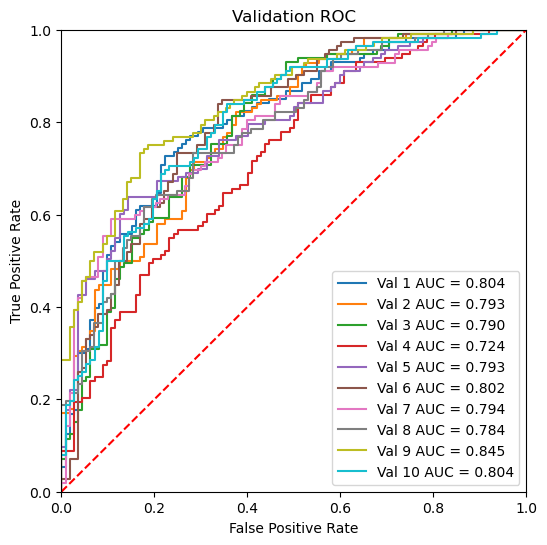

In [16]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

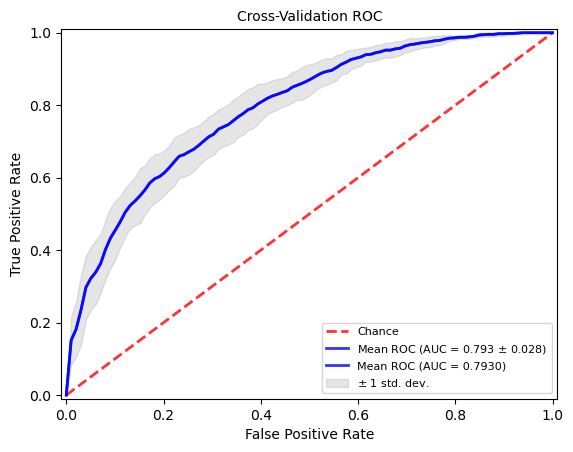

In [17]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [18]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [19]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [20]:
my_calculate_metrics_list_val

[{'SN': 0.5752212389380531,
  'SP': 0.8482142857142857,
  'ACC': 0.7111111111111111,
  'MCC': 0.43990670252429204,
  'Recall': 0.5752212389380531,
  'Precision': 0.7926829268292683,
  'F1-score': 0.6666666666666666,
  'Cutoff': 0.5},
 {'SN': 0.8303571428571429,
  'SP': 0.5803571428571429,
  'ACC': 0.7053571428571429,
  'MCC': 0.4241838902989075,
  'Recall': 0.8303571428571429,
  'Precision': 0.6642857142857143,
  'F1-score': 0.7380952380952381,
  'Cutoff': 0.5},
 {'SN': 0.7345132743362832,
  'SP': 0.6785714285714286,
  'ACC': 0.7066666666666667,
  'MCC': 0.4137718417850436,
  'Recall': 0.7345132743362832,
  'Precision': 0.6974789915966386,
  'F1-score': 0.7155172413793104,
  'Cutoff': 0.5},
 {'SN': 0.4690265486725664,
  'SP': 0.8125,
  'ACC': 0.64,
  'MCC': 0.29961479549163994,
  'Recall': 0.4690265486725664,
  'Precision': 0.7162162162162162,
  'F1-score': 0.5668449197860963,
  'Cutoff': 0.5},
 {'SN': 0.6814159292035398,
  'SP': 0.7410714285714286,
  'ACC': 0.7111111111111111,
  'MCC'

In [21]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.575221,0.848214,0.711111,0.439907,0.575221,0.792683,0.666667,0.5
1,0.830357,0.580357,0.705357,0.424184,0.830357,0.664286,0.738095,0.5
2,0.734513,0.678571,0.706667,0.413772,0.734513,0.697479,0.715517,0.5
3,0.469027,0.812500,0.640000,0.299615,0.469027,0.716216,0.566845,0.5
4,0.681416,0.741071,0.711111,0.423190,0.681416,0.726415,0.703196,0.5
5,0.598214,0.805310,0.702222,0.412623,0.598214,0.752809,0.666667,0.5
6,0.785714,0.601770,0.693333,0.394078,0.785714,0.661654,0.718367,0.5
7,0.741071,0.628319,0.684444,0.371688,0.741071,0.664000,0.700422,0.5
8,0.723214,0.831858,0.777778,0.558526,0.723214,0.810000,0.764151,0.5
9,0.732143,0.705357,0.718750,0.437657,0.732143,0.713043,0.722467,0.5


In [22]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.575221,0.848214,0.711111,0.439907,0.575221,0.792683,0.666667,0.5
1,0.830357,0.580357,0.705357,0.424184,0.830357,0.664286,0.738095,0.5
2,0.734513,0.678571,0.706667,0.413772,0.734513,0.697479,0.715517,0.5
3,0.469027,0.812500,0.640000,0.299615,0.469027,0.716216,0.566845,0.5
4,0.681416,0.741071,0.711111,0.423190,0.681416,0.726415,0.703196,0.5
5,0.598214,0.805310,0.702222,0.412623,0.598214,0.752809,0.666667,0.5
6,0.785714,0.601770,0.693333,0.394078,0.785714,0.661654,0.718367,0.5
7,0.741071,0.628319,0.684444,0.371688,0.741071,0.664000,0.700422,0.5
8,0.723214,0.831858,0.777778,0.558526,0.723214,0.810000,0.764151,0.5
9,0.732143,0.705357,0.718750,0.437657,0.732143,0.713043,0.722467,0.5


In [23]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [24]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [25]:
roc_auc_list_indep

[0.8169642857142857,
 0.7822066326530612,
 0.8078762755102041,
 0.7756696428571429,
 0.7889827806122449,
 0.8142538265306123,
 0.8146524234693878,
 0.7877072704081632,
 0.7928890306122449,
 0.8045280612244897]

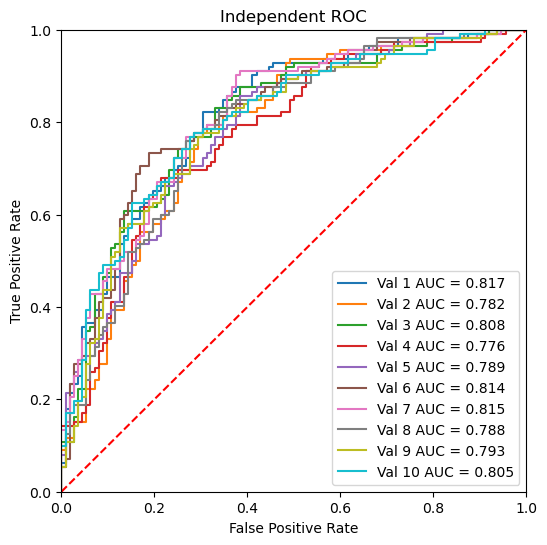

In [26]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

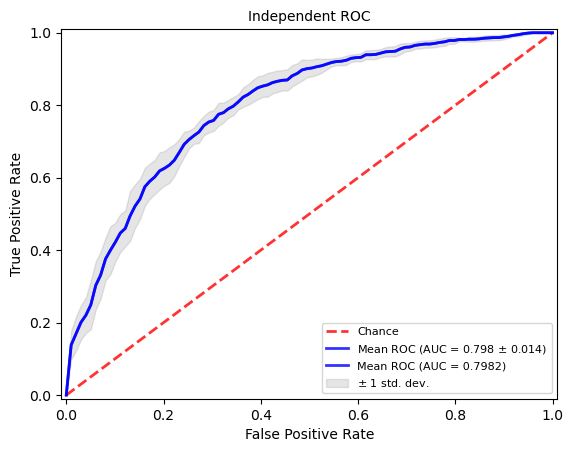

In [27]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [28]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [29]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [30]:
my_calculate_metrics_list_indep

[{'SN': 0.5357142857142857,
  'SP': 0.8660714285714286,
  'ACC': 0.7008928571428571,
  'MCC': 0.42568539285636187,
  'Recall': 0.5357142857142857,
  'Precision': 0.8,
  'F1-score': 0.6417112299465241,
  'Cutoff': 0.5},
 {'SN': 0.8125,
  'SP': 0.6428571428571429,
  'ACC': 0.7276785714285714,
  'MCC': 0.4620543401462305,
  'Recall': 0.8125,
  'Precision': 0.6946564885496184,
  'F1-score': 0.7489711934156379,
  'Cutoff': 0.5},
 {'SN': 0.7589285714285714,
  'SP': 0.7232142857142857,
  'ACC': 0.7410714285714286,
  'MCC': 0.4824506406770077,
  'Recall': 0.7589285714285714,
  'Precision': 0.7327586206896551,
  'F1-score': 0.7456140350877193,
  'Cutoff': 0.5},
 {'SN': 0.5357142857142857,
  'SP': 0.8482142857142857,
  'ACC': 0.6919642857142857,
  'MCC': 0.40417032690385807,
  'Recall': 0.5357142857142857,
  'Precision': 0.7792207792207793,
  'F1-score': 0.6349206349206349,
  'Cutoff': 0.5},
 {'SN': 0.625,
  'SP': 0.7767857142857143,
  'ACC': 0.7008928571428571,
  'MCC': 0.40649560648372973,
  '

In [31]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.535714,0.866071,0.700893,0.425685,0.535714,0.800000,0.641711,0.5
1,0.812500,0.642857,0.727679,0.462054,0.812500,0.694656,0.748971,0.5
2,0.758929,0.723214,0.741071,0.482451,0.758929,0.732759,0.745614,0.5
3,0.535714,0.848214,0.691964,0.404170,0.535714,0.779221,0.634921,0.5
4,0.625000,0.776786,0.700893,0.406496,0.625000,0.736842,0.676329,0.5
5,0.687500,0.839286,0.763393,0.532961,0.687500,0.810526,0.743961,0.5
6,0.803571,0.642857,0.723214,0.452308,0.803571,0.692308,0.743802,0.5
7,0.785714,0.696429,0.741071,0.484076,0.785714,0.721311,0.752137,0.5
8,0.616071,0.803571,0.709821,0.427220,0.616071,0.758242,0.679803,0.5
9,0.714286,0.758929,0.736607,0.473687,0.714286,0.747664,0.730594,0.5


In [32]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.535714,0.866071,0.700893,0.425685,0.535714,0.800000,0.641711,0.5
1,0.812500,0.642857,0.727679,0.462054,0.812500,0.694656,0.748971,0.5
2,0.758929,0.723214,0.741071,0.482451,0.758929,0.732759,0.745614,0.5
3,0.535714,0.848214,0.691964,0.404170,0.535714,0.779221,0.634921,0.5
4,0.625000,0.776786,0.700893,0.406496,0.625000,0.736842,0.676329,0.5
5,0.687500,0.839286,0.763393,0.532961,0.687500,0.810526,0.743961,0.5
6,0.803571,0.642857,0.723214,0.452308,0.803571,0.692308,0.743802,0.5
7,0.785714,0.696429,0.741071,0.484076,0.785714,0.721311,0.752137,0.5
8,0.616071,0.803571,0.709821,0.427220,0.616071,0.758242,0.679803,0.5
9,0.714286,0.758929,0.736607,0.473687,0.714286,0.747664,0.730594,0.5


In [33]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\base_data_NEDD_K\data_5k\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

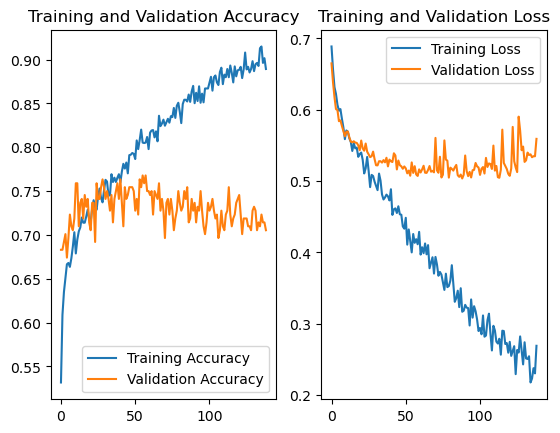

In [35]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()